# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
EXP_NAME = "microsoft-BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"


In [2]:
import os
import time

# wait_to_make = "deberta-large-large512-fold3.txt"
# count = 0
# while 1:
#     if os.path.exists(wait_to_make):
#         break
#     print(f'sleep {count} h')
#     time.sleep(3600)
#     count+=1
    

In [3]:
# ! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime

INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
dt_now = datetime.datetime.now()

# date = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
 
OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
   
    # if size=="small":
    #     hidden_state = hiddden_state_fix = 512
    # elif size=="base":
    #     hidden_state = hiddden_state_fix = 768
    # elif size == "large":
    #     hidden_state = hiddden_state_fix = 1024
    # elif size == "xlarge":
    #     hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=16
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=3
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [8]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [9]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.0
transformers.__version__: 4.16.2
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [10]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [11]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [12]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [13]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

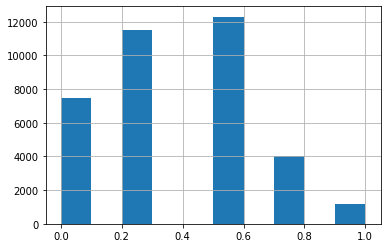

In [14]:
train['score'].hist()

In [15]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [16]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    12158
1    12158
2    12157
dtype: int64

In [17]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [18]:
# !pip install --no-cache-dir sentencepiece
CFG.model

'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'

In [19]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



# Dataset

In [20]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 112


In [21]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [22]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [23]:
# # ====================================================
# # Model
# # ====================================================
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size, cfg.hidden_state),
#             nn.Tanh(),
#             nn.Linear(cfg.hidden_state, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
#         # feature = torch.mean(last_hidden_states, 1)
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         return output
    
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output
    


# Helpler functions

In [24]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [25]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [26]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1519] Elapsed 0m 32s (remain 817m 23s) Loss: 0.6860(0.6860) Grad: 57853.5859  LR: 0.00002000  
Epoch: [1][100/1519] Elapsed 1m 56s (remain 27m 20s) Loss: 0.6533(0.6537) Grad: 20247.8555  LR: 0.00001999  
Epoch: [1][200/1519] Elapsed 2m 46s (remain 18m 12s) Loss: 0.6603(0.6413) Grad: 24239.5195  LR: 0.00001995  
Epoch: [1][300/1519] Elapsed 3m 37s (remain 14m 41s) Loss: 0.6396(0.6330) Grad: 21064.7500  LR: 0.00001988  
Epoch: [1][400/1519] Elapsed 4m 25s (remain 12m 20s) Loss: 0.6245(0.6232) Grad: 20499.8379  LR: 0.00001979  
Epoch: [1][500/1519] Elapsed 5m 16s (remain 10m 42s) Loss: 0.6560(0.6167) Grad: 27007.7012  LR: 0.00001967  
Epoch: [1][600/1519] Elapsed 6m 6s (remain 9m 19s) Loss: 0.5003(0.6110) Grad: 19156.1582  LR: 0.00001952  
Epoch: [1][700/1519] Elapsed 6m 56s (remain 8m 6s) Loss: 0.6560(0.6073) Grad: 22862.1543  LR: 0.00001935  
Epoch: [1][800/1519] Elapsed 7m 48s (remain 7m 0s) Loss: 0.7250(0.6042) Grad: 31058.9023  LR: 0.00001916  
Epoch: [1][900/1519] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/760] Elapsed 0m 0s (remain 3m 12s) Loss: 0.4972(0.4972) 
EVAL: [100/760] Elapsed 0m 10s (remain 1m 5s) Loss: 0.6115(0.5563) 
EVAL: [200/760] Elapsed 0m 19s (remain 0m 55s) Loss: 0.5100(0.5530) 
EVAL: [300/760] Elapsed 0m 30s (remain 0m 46s) Loss: 0.4954(0.5587) 
EVAL: [400/760] Elapsed 0m 42s (remain 0m 37s) Loss: 0.6214(0.5606) 
EVAL: [500/760] Elapsed 0m 53s (remain 0m 27s) Loss: 0.3938(0.5602) 
EVAL: [600/760] Elapsed 1m 3s (remain 0m 16s) Loss: 0.6047(0.5603) 
EVAL: [700/760] Elapsed 1m 14s (remain 0m 6s) Loss: 0.5223(0.5603) 


Epoch 1 - avg_train_loss: 0.5869  avg_val_loss: 0.5592  time: 835s
Epoch 1 - Score: 0.7878
Epoch 1 - Save Best Score: 0.7878 Model


EVAL: [759/760] Elapsed 1m 21s (remain 0m 0s) Loss: 0.5041(0.5592) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/1519] Elapsed 0m 1s (remain 41m 1s) Loss: 0.4959(0.4959) Grad: 218842.1250  LR: 0.00001707  
Epoch: [2][100/1519] Elapsed 0m 37s (remain 8m 40s) Loss: 0.7198(0.5569) Grad: 333098.5625  LR: 0.00001669  
Epoch: [2][200/1519] Elapsed 1m 15s (remain 8m 12s) Loss: 0.4859(0.5443) Grad: 49786.9219  LR: 0.00001630  
Epoch: [2][300/1519] Elapsed 1m 55s (remain 7m 47s) Loss: 0.5492(0.5463) Grad: 59657.4453  LR: 0.00001589  
Epoch: [2][400/1519] Elapsed 2m 38s (remain 7m 21s) Loss: 0.4882(0.5471) Grad: 104608.8203  LR: 0.00001547  
Epoch: [2][500/1519] Elapsed 3m 20s (remain 6m 47s) Loss: 0.4778(0.5450) Grad: 79034.7578  LR: 0.00001503  
Epoch: [2][600/1519] Elapsed 4m 2s (remain 6m 9s) Loss: 0.5515(0.5449) Grad: 49640.5664  LR: 0.00001457  
Epoch: [2][700/1519] Elapsed 4m 46s (remain 5m 34s) Loss: 0.4504(0.5459) Grad: 48606.1172  LR: 0.00001411  
Epoch: [2][800/1519] Elapsed 5m 29s (remain 4m 54s) Loss: 0.4493(0.5457) Grad: 30899.5508  LR: 0.00001363  
Epoch: [2][900/1519] Elapsed 6

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/760] Elapsed 0m 0s (remain 3m 47s) Loss: 0.4910(0.4910) 
EVAL: [100/760] Elapsed 0m 8s (remain 0m 52s) Loss: 0.5893(0.5456) 
EVAL: [200/760] Elapsed 0m 15s (remain 0m 43s) Loss: 0.5096(0.5439) 
EVAL: [300/760] Elapsed 0m 23s (remain 0m 35s) Loss: 0.4760(0.5508) 
EVAL: [400/760] Elapsed 0m 31s (remain 0m 28s) Loss: 0.6331(0.5529) 
EVAL: [500/760] Elapsed 0m 39s (remain 0m 20s) Loss: 0.3593(0.5518) 
EVAL: [600/760] Elapsed 0m 46s (remain 0m 12s) Loss: 0.6024(0.5508) 
EVAL: [700/760] Elapsed 0m 54s (remain 0m 4s) Loss: 0.5192(0.5512) 


Epoch 2 - avg_train_loss: 0.5435  avg_val_loss: 0.5502  time: 623s
Epoch 2 - Score: 0.8118
Epoch 2 - Save Best Score: 0.8118 Model


EVAL: [759/760] Elapsed 0m 59s (remain 0m 0s) Loss: 0.4867(0.5502) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/1519] Elapsed 0m 0s (remain 8m 56s) Loss: 0.5449(0.5449) Grad: inf  LR: 0.00001000  
Epoch: [3][100/1519] Elapsed 0m 27s (remain 6m 20s) Loss: 0.4797(0.5216) Grad: 58228.6055  LR: 0.00000948  
Epoch: [3][200/1519] Elapsed 0m 53s (remain 5m 53s) Loss: 0.5249(0.5237) Grad: 75099.5078  LR: 0.00000897  
Epoch: [3][300/1519] Elapsed 1m 20s (remain 5m 26s) Loss: 0.4690(0.5298) Grad: 69442.0859  LR: 0.00000846  
Epoch: [3][400/1519] Elapsed 1m 47s (remain 4m 59s) Loss: 0.6140(0.5308) Grad: 151053.9062  LR: 0.00000795  
Epoch: [3][500/1519] Elapsed 2m 14s (remain 4m 32s) Loss: 0.5449(0.5308) Grad: 97238.5625  LR: 0.00000744  
Epoch: [3][600/1519] Elapsed 2m 41s (remain 4m 5s) Loss: 0.4497(0.5308) Grad: 96855.3672  LR: 0.00000695  
Epoch: [3][700/1519] Elapsed 3m 7s (remain 3m 39s) Loss: 0.5102(0.5317) Grad: 62740.8320  LR: 0.00000646  
Epoch: [3][800/1519] Elapsed 3m 34s (remain 3m 12s) Loss: 0.5647(0.5306) Grad: 47204.0898  LR: 0.00000598  
Epoch: [3][900/1519] Elapsed 4m 1s (rem

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][1518/1519] Elapsed 6m 47s (remain 0m 0s) Loss: 0.5205(0.5296) Grad: 25106.6445  LR: 0.00000293  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/760] Elapsed 0m 0s (remain 3m 2s) Loss: 0.5028(0.5028) 
EVAL: [100/760] Elapsed 0m 7s (remain 0m 51s) Loss: 0.6099(0.5526) 
EVAL: [200/760] Elapsed 0m 15s (remain 0m 43s) Loss: 0.5111(0.5498) 
EVAL: [300/760] Elapsed 0m 23s (remain 0m 35s) Loss: 0.4660(0.5555) 
EVAL: [400/760] Elapsed 0m 31s (remain 0m 27s) Loss: 0.6224(0.5571) 
EVAL: [500/760] Elapsed 0m 38s (remain 0m 20s) Loss: 0.3531(0.5557) 
EVAL: [600/760] Elapsed 0m 46s (remain 0m 12s) Loss: 0.5986(0.5553) 
EVAL: [700/760] Elapsed 0m 54s (remain 0m 4s) Loss: 0.5114(0.5559) 


Epoch 3 - avg_train_loss: 0.5296  avg_val_loss: 0.5548  time: 466s
Epoch 3 - Score: 0.8187
Epoch 3 - Save Best Score: 0.8187 Model


EVAL: [759/760] Elapsed 0m 58s (remain 0m 0s) Loss: 0.4795(0.5548) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/1519] Elapsed 0m 0s (remain 9m 26s) Loss: 0.5410(0.5410) Grad: 124344.8594  LR: 0.00000293  
Epoch: [4][100/1519] Elapsed 0m 27s (remain 6m 21s) Loss: 0.3199(0.5262) Grad: 96213.0469  LR: 0.00000257  
Epoch: [4][200/1519] Elapsed 0m 53s (remain 5m 53s) Loss: 0.3692(0.5213) Grad: 59347.8906  LR: 0.00000224  
Epoch: [4][300/1519] Elapsed 1m 20s (remain 5m 26s) Loss: 0.5094(0.5209) Grad: 52905.7930  LR: 0.00000192  
Epoch: [4][400/1519] Elapsed 1m 47s (remain 4m 59s) Loss: 0.5493(0.5235) Grad: 148147.2344  LR: 0.00000163  
Epoch: [4][500/1519] Elapsed 2m 14s (remain 4m 33s) Loss: 0.4570(0.5248) Grad: 58443.3984  LR: 0.00000136  
Epoch: [4][600/1519] Elapsed 2m 41s (remain 4m 6s) Loss: 0.5132(0.5240) Grad: 106957.1094  LR: 0.00000111  
Epoch: [4][700/1519] Elapsed 3m 8s (remain 3m 39s) Loss: 0.5296(0.5226) Grad: 49774.5000  LR: 0.00000088  
Epoch: [4][800/1519] Elapsed 3m 35s (remain 3m 12s) Loss: 0.5629(0.5227) Grad: 66828.2734  LR: 0.00000068  
Epoch: [4][900/1519] Elapsed 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/760] Elapsed 0m 0s (remain 3m 2s) Loss: 0.4801(0.4801) 
EVAL: [100/760] Elapsed 0m 7s (remain 0m 51s) Loss: 0.6052(0.5504) 
EVAL: [200/760] Elapsed 0m 15s (remain 0m 43s) Loss: 0.5107(0.5493) 
EVAL: [300/760] Elapsed 0m 23s (remain 0m 35s) Loss: 0.4657(0.5551) 
EVAL: [400/760] Elapsed 0m 31s (remain 0m 27s) Loss: 0.6434(0.5563) 
EVAL: [500/760] Elapsed 0m 38s (remain 0m 20s) Loss: 0.3473(0.5550) 
EVAL: [600/760] Elapsed 0m 46s (remain 0m 12s) Loss: 0.6007(0.5549) 
EVAL: [700/760] Elapsed 0m 54s (remain 0m 4s) Loss: 0.5161(0.5555) 


Epoch 4 - avg_train_loss: 0.5227  avg_val_loss: 0.5544  time: 467s
Epoch 4 - Score: 0.8195
Epoch 4 - Save Best Score: 0.8195 Model


EVAL: [759/760] Elapsed 0m 58s (remain 0m 0s) Loss: 0.4766(0.5544) 


========== fold: 0 result ==========
Score: 0.8195
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (func

Epoch: [1][0/1519] Elapsed 0m 0s (remain 8m 57s) Loss: 0.6997(0.6997) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1519] Elapsed 0m 34s (remain 8m 8s) Loss: 0.6504(0.6660) Grad: 29973.1914  LR: 0.00001999  
Epoch: [1][200/1519] Elapsed 1m 8s (remain 7m 26s) Loss: 0.6446(0.6560) Grad: 53129.4727  LR: 0.00001995  
Epoch: [1][300/1519] Elapsed 1m 41s (remain 6m 49s) Loss: 0.5777(0.6500) Grad: 10173.7549  LR: 0.00001988  
Epoch: [1][400/1519] Elapsed 2m 14s (remain 6m 14s) Loss: 0.6136(0.6404) Grad: 16462.7227  LR: 0.00001979  
Epoch: [1][500/1519] Elapsed 2m 48s (remain 5m 42s) Loss: 0.5356(0.6320) Grad: 17289.1016  LR: 0.00001967  
Epoch: [1][600/1519] Elapsed 3m 22s (remain 5m 9s) Loss: 0.6411(0.6257) Grad: 17982.3105  LR: 0.00001952  
Epoch: [1][700/1519] Elapsed 3m 55s (remain 4m 35s) Loss: 0.4884(0.6195) Grad: 13986.1816  LR: 0.00001935  
Epoch: [1][800/1519] Elapsed 4m 29s (remain 4m 1s) Loss: 0.5131(0.6140) Grad: 8523.3008  LR: 0.00001916  
Epoch: [1][900/1519] Elapsed 5m 3s (remain 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/760] Elapsed 0m 2s (remain 25m 58s) Loss: 0.5674(0.5674) 
EVAL: [100/760] Elapsed 0m 15s (remain 1m 38s) Loss: 0.6337(0.5566) 
EVAL: [200/760] Elapsed 0m 27s (remain 1m 17s) Loss: 0.6351(0.5646) 
EVAL: [300/760] Elapsed 0m 40s (remain 1m 1s) Loss: 0.6238(0.5680) 
EVAL: [400/760] Elapsed 0m 52s (remain 0m 47s) Loss: 0.5820(0.5691) 
EVAL: [500/760] Elapsed 1m 5s (remain 0m 33s) Loss: 0.5478(0.5687) 
EVAL: [600/760] Elapsed 1m 18s (remain 0m 20s) Loss: 0.5499(0.5677) 
EVAL: [700/760] Elapsed 1m 31s (remain 0m 7s) Loss: 0.5568(0.5667) 
EVAL: [759/760] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6524(0.5670) 


Epoch 1 - avg_train_loss: 0.5935  avg_val_loss: 0.5670  time: 636s
Epoch 1 - Score: 0.7637
Epoch 1 - Save Best Score: 0.7637 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/1519] Elapsed 0m 0s (remain 8m 33s) Loss: 0.4364(0.4364) Grad: inf  LR: 0.00001707  
Epoch: [2][100/1519] Elapsed 0m 46s (remain 10m 54s) Loss: 0.5261(0.5474) Grad: 89285.1484  LR: 0.00001669  
Epoch: [2][200/1519] Elapsed 1m 27s (remain 9m 31s) Loss: 0.6268(0.5486) Grad: 84107.7578  LR: 0.00001630  
Epoch: [2][300/1519] Elapsed 1m 53s (remain 7m 41s) Loss: 0.5602(0.5486) Grad: 123629.5078  LR: 0.00001589  
Epoch: [2][400/1519] Elapsed 2m 20s (remain 6m 32s) Loss: 0.4683(0.5466) Grad: 49435.1719  LR: 0.00001547  
Epoch: [2][500/1519] Elapsed 2m 47s (remain 5m 40s) Loss: 0.4874(0.5460) Grad: 57213.1328  LR: 0.00001503  
Epoch: [2][600/1519] Elapsed 3m 14s (remain 4m 57s) Loss: 0.5387(0.5453) Grad: 69310.8203  LR: 0.00001457  
Epoch: [2][700/1519] Elapsed 3m 41s (remain 4m 18s) Loss: 0.5004(0.5454) Grad: 83792.6797  LR: 0.00001411  
Epoch: [2][800/1519] Elapsed 4m 8s (remain 3m 42s) Loss: 0.6163(0.5439) Grad: 21186.9316  LR: 0.00001363  
Epoch: [2][900/1519] Elapsed 4m 35s (

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/760] Elapsed 0m 0s (remain 4m 1s) Loss: 0.5856(0.5856) 
EVAL: [100/760] Elapsed 0m 8s (remain 0m 52s) Loss: 0.6243(0.5466) 
EVAL: [200/760] Elapsed 0m 15s (remain 0m 43s) Loss: 0.6381(0.5557) 
EVAL: [300/760] Elapsed 0m 23s (remain 0m 35s) Loss: 0.6218(0.5588) 
EVAL: [400/760] Elapsed 0m 31s (remain 0m 27s) Loss: 0.5713(0.5597) 
EVAL: [500/760] Elapsed 0m 39s (remain 0m 20s) Loss: 0.5197(0.5591) 
EVAL: [600/760] Elapsed 0m 46s (remain 0m 12s) Loss: 0.5371(0.5567) 
EVAL: [700/760] Elapsed 0m 54s (remain 0m 4s) Loss: 0.5170(0.5554) 


Epoch 2 - avg_train_loss: 0.5435  avg_val_loss: 0.5556  time: 500s
Epoch 2 - Score: 0.7958
Epoch 2 - Save Best Score: 0.7958 Model


EVAL: [759/760] Elapsed 0m 59s (remain 0m 0s) Loss: 0.7435(0.5556) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/1519] Elapsed 0m 0s (remain 9m 57s) Loss: 0.5891(0.5891) Grad: 192045.6875  LR: 0.00001000  
Epoch: [3][100/1519] Elapsed 0m 27s (remain 6m 23s) Loss: 0.5317(0.5437) Grad: 88098.3438  LR: 0.00000948  
Epoch: [3][200/1519] Elapsed 0m 54s (remain 5m 55s) Loss: 0.4883(0.5468) Grad: 65143.0938  LR: 0.00000897  
Epoch: [3][300/1519] Elapsed 1m 21s (remain 5m 28s) Loss: 0.4378(0.5411) Grad: 61259.5078  LR: 0.00000846  
Epoch: [3][400/1519] Elapsed 1m 48s (remain 5m 1s) Loss: 0.5708(0.5372) Grad: 73899.1406  LR: 0.00000795  
Epoch: [3][500/1519] Elapsed 2m 15s (remain 4m 34s) Loss: 0.4935(0.5365) Grad: 52033.0820  LR: 0.00000744  
Epoch: [3][600/1519] Elapsed 2m 41s (remain 4m 7s) Loss: 0.5953(0.5368) Grad: 55289.3047  LR: 0.00000695  
Epoch: [3][700/1519] Elapsed 3m 8s (remain 3m 40s) Loss: 0.5292(0.5354) Grad: 56391.6953  LR: 0.00000646  
Epoch: [3][800/1519] Elapsed 3m 35s (remain 3m 13s) Loss: 0.5062(0.5357) Grad: 29158.5391  LR: 0.00000598  
Epoch: [3][900/1519] Elapsed 4m 2

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/760] Elapsed 0m 0s (remain 3m 18s) Loss: 0.5781(0.5781) 
EVAL: [100/760] Elapsed 0m 8s (remain 0m 52s) Loss: 0.6275(0.5479) 
EVAL: [200/760] Elapsed 0m 15s (remain 0m 43s) Loss: 0.6401(0.5570) 
EVAL: [300/760] Elapsed 0m 23s (remain 0m 35s) Loss: 0.6207(0.5604) 
EVAL: [400/760] Elapsed 0m 31s (remain 0m 28s) Loss: 0.5455(0.5611) 
EVAL: [500/760] Elapsed 0m 39s (remain 0m 20s) Loss: 0.5144(0.5610) 
EVAL: [600/760] Elapsed 0m 46s (remain 0m 12s) Loss: 0.5322(0.5590) 
EVAL: [700/760] Elapsed 0m 54s (remain 0m 4s) Loss: 0.4927(0.5573) 


Epoch 3 - avg_train_loss: 0.5356  avg_val_loss: 0.5574  time: 468s
Epoch 3 - Score: 0.8017
Epoch 3 - Save Best Score: 0.8017 Model


EVAL: [759/760] Elapsed 0m 59s (remain 0m 0s) Loss: 0.7370(0.5574) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/1519] Elapsed 0m 0s (remain 10m 49s) Loss: 0.6200(0.6200) Grad: 82065.3906  LR: 0.00000293  
Epoch: [4][100/1519] Elapsed 0m 27s (remain 6m 23s) Loss: 0.5228(0.5247) Grad: 113822.3750  LR: 0.00000257  
Epoch: [4][200/1519] Elapsed 0m 54s (remain 5m 55s) Loss: 0.6120(0.5273) Grad: 211987.7344  LR: 0.00000224  
Epoch: [4][300/1519] Elapsed 1m 21s (remain 5m 28s) Loss: 0.4785(0.5294) Grad: 63732.8281  LR: 0.00000192  
Epoch: [4][400/1519] Elapsed 1m 48s (remain 5m 1s) Loss: 0.5182(0.5258) Grad: 67911.9375  LR: 0.00000163  
Epoch: [4][500/1519] Elapsed 2m 14s (remain 4m 34s) Loss: 0.5685(0.5269) Grad: 28324.7676  LR: 0.00000136  
Epoch: [4][600/1519] Elapsed 2m 41s (remain 4m 7s) Loss: 0.4596(0.5284) Grad: 58021.4531  LR: 0.00000111  
Epoch: [4][700/1519] Elapsed 3m 8s (remain 3m 40s) Loss: 0.4734(0.5289) Grad: 51710.1484  LR: 0.00000088  
Epoch: [4][800/1519] Elapsed 3m 35s (remain 3m 13s) Loss: 0.5817(0.5311) Grad: 36585.7109  LR: 0.00000068  
Epoch: [4][900/1519] Elapsed 4m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/760] Elapsed 0m 0s (remain 2m 58s) Loss: 0.5732(0.5732) 
EVAL: [100/760] Elapsed 0m 8s (remain 0m 52s) Loss: 0.6322(0.5502) 
EVAL: [200/760] Elapsed 0m 15s (remain 0m 44s) Loss: 0.6399(0.5594) 
EVAL: [300/760] Elapsed 0m 23s (remain 0m 35s) Loss: 0.6204(0.5628) 
EVAL: [400/760] Elapsed 0m 31s (remain 0m 28s) Loss: 0.5432(0.5627) 
EVAL: [500/760] Elapsed 0m 39s (remain 0m 20s) Loss: 0.5109(0.5624) 
EVAL: [600/760] Elapsed 0m 46s (remain 0m 12s) Loss: 0.5280(0.5598) 
EVAL: [700/760] Elapsed 0m 54s (remain 0m 4s) Loss: 0.4873(0.5581) 


Epoch 4 - avg_train_loss: 0.5293  avg_val_loss: 0.5583  time: 468s
Epoch 4 - Score: 0.8043
Epoch 4 - Save Best Score: 0.8043 Model


EVAL: [759/760] Elapsed 0m 59s (remain 0m 0s) Loss: 0.7521(0.5583) 


========== fold: 1 result ==========
Score: 0.8043
========== fold: 2 training ==========


========== fold: 2 training ==========


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (func

Epoch: [1][0/1519] Elapsed 0m 0s (remain 8m 45s) Loss: 0.6181(0.6181) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1519] Elapsed 0m 27s (remain 6m 20s) Loss: 0.7197(0.6608) Grad: 37496.2773  LR: 0.00001999  
Epoch: [1][200/1519] Elapsed 0m 53s (remain 5m 53s) Loss: 0.6211(0.6504) Grad: 18391.0801  LR: 0.00001995  
Epoch: [1][300/1519] Elapsed 1m 20s (remain 5m 26s) Loss: 0.5983(0.6418) Grad: 4945.9229  LR: 0.00001988  
Epoch: [1][400/1519] Elapsed 1m 47s (remain 4m 59s) Loss: 0.5489(0.6363) Grad: 16324.0420  LR: 0.00001979  
Epoch: [1][500/1519] Elapsed 2m 14s (remain 4m 32s) Loss: 0.5727(0.6303) Grad: 2209.5356  LR: 0.00001967  
Epoch: [1][600/1519] Elapsed 2m 41s (remain 4m 6s) Loss: 0.6626(0.6237) Grad: 9866.1709  LR: 0.00001952  
Epoch: [1][700/1519] Elapsed 3m 7s (remain 3m 39s) Loss: 0.6007(0.6176) Grad: 3624.0151  LR: 0.00001935  
Epoch: [1][800/1519] Elapsed 3m 34s (remain 3m 12s) Loss: 0.6215(0.6129) Grad: 4280.3228  LR: 0.00001916  
Epoch: [1][900/1519] Elapsed 4m 1s (remain 2m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][1518/1519] Elapsed 6m 47s (remain 0m 0s) Loss: 0.4982(0.5920) Grad: 2234.2876  LR: 0.00001707  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/760] Elapsed 0m 0s (remain 3m 36s) Loss: 0.6104(0.6104) 
EVAL: [100/760] Elapsed 0m 7s (remain 0m 51s) Loss: 0.6122(0.5571) 
EVAL: [200/760] Elapsed 0m 15s (remain 0m 43s) Loss: 0.7014(0.5574) 
EVAL: [300/760] Elapsed 0m 23s (remain 0m 35s) Loss: 0.5553(0.5580) 
EVAL: [400/760] Elapsed 0m 31s (remain 0m 27s) Loss: 0.6300(0.5594) 
EVAL: [500/760] Elapsed 0m 38s (remain 0m 20s) Loss: 0.5292(0.5589) 
EVAL: [600/760] Elapsed 0m 46s (remain 0m 12s) Loss: 0.6087(0.5590) 
EVAL: [700/760] Elapsed 0m 54s (remain 0m 4s) Loss: 0.6500(0.5598) 


Epoch 1 - avg_train_loss: 0.5920  avg_val_loss: 0.5604  time: 467s
Epoch 1 - Score: 0.7820
Epoch 1 - Save Best Score: 0.7820 Model


EVAL: [759/760] Elapsed 0m 58s (remain 0m 0s) Loss: 0.5378(0.5604) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/1519] Elapsed 0m 0s (remain 9m 18s) Loss: 0.4801(0.4801) Grad: 125935.3047  LR: 0.00001707  
Epoch: [2][100/1519] Elapsed 0m 27s (remain 6m 21s) Loss: 0.5442(0.5532) Grad: 59679.0859  LR: 0.00001670  
Epoch: [2][200/1519] Elapsed 0m 53s (remain 5m 53s) Loss: 0.4627(0.5477) Grad: 14493.8604  LR: 0.00001630  
Epoch: [2][300/1519] Elapsed 1m 20s (remain 5m 27s) Loss: 0.4702(0.5452) Grad: 10248.0879  LR: 0.00001589  
Epoch: [2][400/1519] Elapsed 1m 47s (remain 5m 0s) Loss: 0.4833(0.5442) Grad: 9413.8662  LR: 0.00001547  
Epoch: [2][500/1519] Elapsed 2m 14s (remain 4m 33s) Loss: 0.6021(0.5445) Grad: 10990.8701  LR: 0.00001503  
Epoch: [2][600/1519] Elapsed 2m 41s (remain 4m 6s) Loss: 0.4803(0.5449) Grad: 18844.1465  LR: 0.00001458  
Epoch: [2][700/1519] Elapsed 3m 8s (remain 3m 39s) Loss: 0.5573(0.5444) Grad: 9766.4961  LR: 0.00001411  
Epoch: [2][800/1519] Elapsed 3m 35s (remain 3m 13s) Loss: 0.5564(0.5441) Grad: 12337.6201  LR: 0.00001363  
Epoch: [2][900/1519] Elapsed 4m 2s 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][1518/1519] Elapsed 6m 48s (remain 0m 0s) Loss: 0.5005(0.5431) Grad: 6511.4531  LR: 0.00001001  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/760] Elapsed 0m 0s (remain 3m 11s) Loss: 0.5959(0.5959) 
EVAL: [100/760] Elapsed 0m 7s (remain 0m 51s) Loss: 0.6137(0.5509) 
EVAL: [200/760] Elapsed 0m 15s (remain 0m 43s) Loss: 0.6906(0.5530) 
EVAL: [300/760] Elapsed 0m 23s (remain 0m 35s) Loss: 0.5577(0.5533) 
EVAL: [400/760] Elapsed 0m 31s (remain 0m 27s) Loss: 0.6330(0.5549) 
EVAL: [500/760] Elapsed 0m 37s (remain 0m 19s) Loss: 0.5584(0.5544) 
EVAL: [600/760] Elapsed 0m 44s (remain 0m 11s) Loss: 0.5825(0.5546) 
EVAL: [700/760] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6122(0.5547) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 2 - avg_train_loss: 0.5431  avg_val_loss: 0.5551  time: 463s
Epoch 2 - Score: 0.8048
Epoch 2 - Save Best Score: 0.8048 Model


EVAL: [759/760] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5416(0.5551) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/1519] Elapsed 0m 0s (remain 9m 28s) Loss: 0.5886(0.5886) Grad: 103242.6328  LR: 0.00001000  
Epoch: [3][100/1519] Elapsed 0m 24s (remain 5m 41s) Loss: 0.4742(0.5266) Grad: 142677.4844  LR: 0.00000949  
Epoch: [3][200/1519] Elapsed 0m 48s (remain 5m 16s) Loss: 0.5233(0.5247) Grad: 39213.8438  LR: 0.00000897  
Epoch: [3][300/1519] Elapsed 1m 12s (remain 4m 52s) Loss: 0.6294(0.5257) Grad: 87364.4219  LR: 0.00000846  
Epoch: [3][400/1519] Elapsed 1m 36s (remain 4m 28s) Loss: 0.5741(0.5257) Grad: 46062.2812  LR: 0.00000795  
Epoch: [3][500/1519] Elapsed 2m 0s (remain 4m 4s) Loss: 0.5563(0.5237) Grad: 42184.9688  LR: 0.00000745  
Epoch: [3][600/1519] Elapsed 2m 24s (remain 3m 40s) Loss: 0.5581(0.5252) Grad: 30275.6113  LR: 0.00000695  
Epoch: [3][700/1519] Elapsed 2m 48s (remain 3m 16s) Loss: 0.5606(0.5254) Grad: 43634.0664  LR: 0.00000646  
Epoch: [3][800/1519] Elapsed 3m 12s (remain 2m 52s) Loss: 0.5781(0.5259) Grad: 106572.1641  LR: 0.00000598  
Epoch: [3][900/1519] Elapsed 3

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][1518/1519] Elapsed 6m 30s (remain 0m 0s) Loss: 0.4362(0.5257) Grad: 64077.8672  LR: 0.00000294  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/760] Elapsed 0m 1s (remain 22m 20s) Loss: 0.6068(0.6068) 
EVAL: [100/760] Elapsed 0m 12s (remain 1m 19s) Loss: 0.6043(0.5508) 
EVAL: [200/760] Elapsed 0m 22s (remain 1m 2s) Loss: 0.7305(0.5521) 
EVAL: [300/760] Elapsed 0m 33s (remain 0m 50s) Loss: 0.5584(0.5527) 
EVAL: [400/760] Elapsed 0m 43s (remain 0m 39s) Loss: 0.6182(0.5542) 
EVAL: [500/760] Elapsed 0m 54s (remain 0m 28s) Loss: 0.5383(0.5537) 
EVAL: [600/760] Elapsed 1m 4s (remain 0m 17s) Loss: 0.5786(0.5539) 
EVAL: [700/760] Elapsed 1m 15s (remain 0m 6s) Loss: 0.6672(0.5543) 


Epoch 3 - avg_train_loss: 0.5257  avg_val_loss: 0.5548  time: 474s
Epoch 3 - Score: 0.8095
Epoch 3 - Save Best Score: 0.8095 Model


EVAL: [759/760] Elapsed 1m 22s (remain 0m 0s) Loss: 0.5180(0.5548) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/1519] Elapsed 0m 0s (remain 9m 13s) Loss: 0.6533(0.6533) Grad: 69629.8516  LR: 0.00000293  
Epoch: [4][100/1519] Elapsed 0m 36s (remain 8m 31s) Loss: 0.5410(0.5265) Grad: 61162.0977  LR: 0.00000258  
Epoch: [4][200/1519] Elapsed 1m 12s (remain 7m 57s) Loss: 0.5206(0.5212) Grad: 42472.0156  LR: 0.00000224  
Epoch: [4][300/1519] Elapsed 1m 49s (remain 7m 24s) Loss: 0.5183(0.5224) Grad: 37220.6797  LR: 0.00000193  
Epoch: [4][400/1519] Elapsed 2m 25s (remain 6m 46s) Loss: 0.4619(0.5207) Grad: 60166.2070  LR: 0.00000163  
Epoch: [4][500/1519] Elapsed 3m 2s (remain 6m 11s) Loss: 0.6453(0.5223) Grad: 45243.8320  LR: 0.00000136  
Epoch: [4][600/1519] Elapsed 3m 39s (remain 5m 35s) Loss: 0.4565(0.5236) Grad: 58833.3711  LR: 0.00000111  
Epoch: [4][700/1519] Elapsed 4m 16s (remain 4m 59s) Loss: 0.5332(0.5236) Grad: 52991.7305  LR: 0.00000089  
Epoch: [4][800/1519] Elapsed 4m 54s (remain 4m 24s) Loss: 0.3692(0.5246) Grad: 90417.8359  LR: 0.00000069  
Epoch: [4][900/1519] Elapsed 5m 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/760] Elapsed 0m 0s (remain 3m 24s) Loss: 0.6043(0.6043) 
EVAL: [100/760] Elapsed 0m 8s (remain 0m 52s) Loss: 0.6067(0.5511) 
EVAL: [200/760] Elapsed 0m 15s (remain 0m 44s) Loss: 0.7328(0.5524) 
EVAL: [300/760] Elapsed 0m 23s (remain 0m 36s) Loss: 0.5605(0.5529) 
EVAL: [400/760] Elapsed 0m 31s (remain 0m 28s) Loss: 0.6183(0.5544) 
EVAL: [500/760] Elapsed 0m 39s (remain 0m 20s) Loss: 0.5382(0.5540) 
EVAL: [600/760] Elapsed 0m 46s (remain 0m 12s) Loss: 0.5781(0.5543) 
EVAL: [700/760] Elapsed 0m 54s (remain 0m 4s) Loss: 0.6737(0.5547) 


Epoch 4 - avg_train_loss: 0.5231  avg_val_loss: 0.5551  time: 568s
Epoch 4 - Score: 0.8102
Epoch 4 - Save Best Score: 0.8102 Model


EVAL: [759/760] Elapsed 0m 59s (remain 0m 0s) Loss: 0.5119(0.5551) 


========== fold: 2 result ==========
Score: 0.8102
========== CV ==========
Score: 0.8112


In [27]:
print(f'{time.time()-start} hour')

6534.690112829208 hour


In [28]:
!touch trained_list/microsoft-BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext.txt 

In [29]:
# https://www.kaggle.com/datasets/trevenanter/pppmdeberta